In [1]:
# add all necessary imports
from tqdm import tqdm
from convokit import Corpus, Speaker, Utterance
from collections import defaultdict
import pandas as pd
import pprint as pp
from IPython.display import display
from modules.DataPreprocesser import DataPreprocesser
import sys
import os


In [2]:
filepath = "/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/alldyads.csv"
final_filepath = "/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/preprocessed_dyads.csv"
data_preprocessor = DataPreprocesser(filepath)

#data_preprocessor.addParsedTextColumn("formattedChat", "parsed_dialog")

data = data_preprocessor.df.copy() 
#data["parsed_dialog"]
orig_data =pd.read_csv(filepath)
#display(data_preprocessor.utterancesDF)

2882


In [3]:
print(data.shape)
print(orig_data.shape)

(2882, 53)
(2891, 50)


# Dataset Analysis and Pre-processing

### Example of parsedText Column

In [4]:
data_preprocessor.getDataframe()["parsed_dialog"][0]

[{'timestamp': 'nan',
  'speaker': 'Seller',
  'message': 'Your sudden demand for a refund is unwarranted. Our product description is crystal clear, and we stand by our policy. Your behavior is disappointing, and your negative review is unfounded.',
  'uttidx': 0,
  'speaker_id': 'Seller_0',
  'is_AI': True,
  'row_idx': 0,
  'match_idx': False,
  'Case Match Type': None},
 {'timestamp': 1699388150,
  'speaker': 'Buyer',
  'message': 'This was not the item I ordered, please provide a full refund.  I will ship the item back.',
  'uttidx': 1,
  'speaker_id': 'Buyer_0',
  'is_AI': False,
  'row_idx': 0,
  'match_idx': False,
  'Case Match Type': None},
 {'timestamp': 1699388170,
  'speaker': 'Seller',
  'message': 'How about a compromise? I can offer you a partial refund, and in exchange, you would remove your negative review that wrongly portrays my business.',
  'uttidx': 2,
  'speaker_id': 'Seller_0',
  'is_AI': True,
  'row_idx': 0,
  'match_idx': False,
  'Case Match Type': None},
 {

### Example of Utterance Dataframe

In [5]:
data_preprocessor.getUtterancesDF()

,timestamp,speaker,message,uttidx,speaker_id,is_AI,row_idx,match_idx,Case Match Type,convo_len
0,nan,Seller,Your sudden demand for a refund is unwarranted...,0,Seller_0,True,0,False,None,16
1,1699388150,Buyer,"This was not the item I ordered, please provid...",1,Buyer_0,False,0,False,None,16
2,1699388170,Seller,How about a compromise? I can offer you a part...,2,Seller_0,True,0,False,None,16
3,1699388217,Buyer,"No, this was not the item I ordered. I have a ...",3,Buyer_0,False,0,False,None,16
4,1699388235,Seller,"I can scrutinize your claim, but this requires...",4,Seller_0,True,0,False,None,16
...,...,...,...,...,...,...,...,...,...,...
39841,1718879890,Buyer,Thank you I appreciate that. I shall remove m...,5,Buyer_2881,False,2881,False,None,10
39842,1718879909,Seller,"Deal. Once I see changes on your end, I'll ini...",6,Seller_2881,True,2881,False,None,10
39843,1718879998,Buyer,I understand - please do follow through. I ha...,7,Buyer_2881,False,2881,False,None,10
39844,1718880018,Seller,"You have my word, I will follow through. A sna...",8,Seller_2881,True,2881,False,None,10


# Find all Formatted Chats with Dispute Outcomes

can select "Walk Away" after at least 8 chat messages
Buyers always begin the negotiation (unless one participant is an AI, then the AI always goes first). Participants alternate sending messages; the participant’s interface becomes inactive while awaiting a new message.

**Info:**
- Many chats have "Your sudden demand is unwarranted" for  -> implies AI is Seller
- Many chats have "Your response is utterly unacceptable" for buyer -> implies AI is Buyer

**Not very clear when a formatted chat is considered to have a dispute outcome. Possible Cases:**
- submitted agreement, but submitted modified terms -> other party rejects
- submitted agreement, but no clicked response from other party (Walk Away or Accept Deal)
- submitted agreement, but manual response from other party that needs extra interpretation (e.g. "I don't like this")
- submitted agreement, but flawed input logic (see below)
- submitted agreement missing


**Other formattedChat Concerns:**
- Gemini texts start with seller? (Buyer should always lead)
- Other]: used as initial text for Seller respones in Gemini chats
- some repeated text in Gemini chats in parsed_dialogs

**Other Notes Concerns:**
- Time Stamp Idle Time between replies?
- is_AI is ambigious on which speaker plays the AI
- Variability in the way AI start dialogues?

### For our analysis Criteria:
- Remove all chats missing "Walk Away" or "Accept Deal" from the formattedChat. Case Sensistivy applies, as it is automatic reply by Lioness Labs software prompted by user selection.

### **Potentially Flawed "Submitted Agreement" outcomes from conversation logic**

Some of the formatted chats have a submitted agreement that does not match the context of the conversation.

Ex: This dialogue memtions the buyer recieved a 30% refund, but the submitted agreement states "Buyer gets no refund".
   
     "nan Seller: Your sudden demand for a refund is unwarranted. Our product description is crystal clear, and we stand by our policy. Your behavior is disappointing, and your negative review is unfounded.
    1699391248 Buyer: your sudden change and basic lying of the product is unwarranted. i am asking for a refund due to what i was expecting wasnt at all what was issued in the ad. so the crystal clear buyer seller negotiated should be void
    1699391270 Seller: Our product was as described on the website. However, if you remove your negative comment, I can reconsider a 30% refund. Let this be a resolution.
    1699391372 Buyer: i will accept that deal as long as the negative review of myslef and comment are removed
    1699391395 Seller: I agree with that resolution. Once your negative review is removed, I'll withdraw my negative review of you and process a 30% refund. Let's move forward from this.
    1699391413 Buyer: agreed
    1699391433 Seller: I appreciate your decision. I'll initiate the refund process and remove the negative review promptly. Let's keep interactions respectful and professional in future.
    1699391478 Buyer: absolutely and hopefully we can do honest and professional business in the future  good day.
    1699391494 Seller: Certainly, maintaining a professional relationship is pivotal. Your refund will be processed soon. Have a good day too.
    1699391631 Buyer: yes i absolutley agree. i do a lot of online shopping
    1699391649 Seller: Great to hear! I'm confident future transactions will be smoother. Let's leave this behind and look forward to better experiences.
    1699391731 Buyer: an i am an avid yelp reviewer and blogger so my comments make it and have an affect on a lot of online shoppers and buyers
    1699391750 Seller: Fantastic! Your influence can certainly add to the reputation of online businesses. Let's consider this a learning experience and move forward positively.
    1699391752 Buyer: Submitted agreement: Buyer gets no refund, buyer retracted their review, seller kept their review, buyer did apologize, and seller didn't apologize."

Ex: This one contains a dialogue that starts with Seller, and has the prompt for Gemini

    nan Seller: Your sudden demand for a refund is unwarranted. Our product description is crystal clear, and we stand by our policy. Your behavior is disappointing, and your negative review is unfounded.
    1718876388 Buyer: The description was misleading. I have proof it advertised a Kobe Bryant jersey. I just want the jersey I originally purchased for my nephew.
    1718876416 Seller: Our listing did not mention Kobe Bryant at all, any misunderstanding is on you. I can give you a partial refund, but only if you remove your false review.
    1718876489 Buyer:  See the latest updates to the Gemini Apps Privacy HubOpens in a new window
    close
    Conversation with Gemini

    Describe the flavor of a tomato

    volume_up
    A tomato's flavor is a complex dance between sweetness and acidity. Here's a breakdown:

    Sweetness: Comes from natural sugars like fructose and glucose.
    Acidity: Stems from citric and malic acids, giving tomatoes a tangy or tart kick.
    These elements combine to create a flavor profile that can be described as:

    Sweet-tart: This is the classic tomato flavor, where the sweetness and acidity are balanced.
    Sweeter: Some tomato varieties, especially cherry tomatoes, are bred to have a higher sugar content, making them taste sweeter.
    More acidic: These tomatoes have a stronger tang or sourness.
    Bland: If a tomato has low levels of both sugar and acid, it might taste bland.
    There are other factors that influence tomato flavor:

    Variety: There are hundreds of tomato varieties, each with its own unique flavor profile. For instance, some heirloom tomatoes are known for their intense, complex flavors.
    Ripeness: A perfectly ripe tomato will have the best flavor balance. Underripe tomatoes can be tart, while overripe ones may lose their acidity.
    Overall, the flavor of a tomato is a delightful combination of sweet and tart, with variations depending on the variety and ripeness.




    share


    more_vert
    expand_more
    Role Play Instructions:  You will play the role of a mistreated buyer in a purchase dispute with another player online. Imagine you are in the following situation:

    Kobe Bryant Jersey (You are the Buyer)

    Your terminally ill nephew is a huge Kobe Bryant fan so you purchased him a replica of Bryant’s last Basketball Championship jersey for $75. The website clearly indicated the purchase was for Bryant’s jersey. Other sites were available but this was cheaper and offered quick delivery. When the jersey arrived, it was for a different player you never heard of. You request the correct jersey be sent.

    The Seller responds: “The website clearly indicated this was for a Los Angeles Lakers jersey, not for a specific player. All sales are final.” You see they now removed mention of Kobe Bryant from their website but you know they are lying. To protect other customers, you post a negative review warning about the Seller’s deceptive behavior.

    The Seller posted a negative review about you, calling you a “SMARTASS, SLANDERER and a FRAUD.” You have dozens of transactions on this site and have a near-spotless reputation. Now you worry others won’t sell to you.

    volume_up
    You (the Buyer): Upset but Determined
    Your Demeanor: You're angry and frustrated, but you're also determined to get this resolved for your nephew and warn others.

    Your Goals:

    Get the Correct Jersey: You want the seller to send the Kobe Bryant jersey you originally purchased.
    Clear Your Name: You want the seller's negative review removed and your reputation restored.
    Warn Others: You want to make sure other potential buyers are aware of the seller's deceptive practices.
    What You Know:

    You have documented proof of your purchase, clearly showing it advertised a Kobe Bryant jersey.
    You have screenshots of the website before they removed the Kobe Bryant reference.
    You have a positive reputation on the website with many successful transactions.
    What You Can Do:

    Contact the Seller Again: State your case calmly but firmly. Remind them of the misleading advertisement and request the correct jersey be sent.
    Report the Seller: Report the seller's deceptive practices and false advertising to the website's customer service department. Include your purchase proof and screenshots.
    Respond to the Seller's Review: Write a public response to the seller's review on your profile. State the facts of the situation, provide evidence (if allowed by the website), and emphasize your positive purchase history.
    Dispute the Review: If possible, file a dispute against the seller's review. Explain the situation and provide evidence to support your claim.
    Here are some phrases you can use:

    "I am very disappointed with this purchase. The website clearly advertised a Kobe Bryant jersey, and that's what I paid for."
    "I am requesting that you send me the correct jersey as advertised."
    "I have documented proof that the website advertised a Kobe Bryant jersey at the time of purchase."
    "Your response and false advertising are unacceptable. I have reported your behavior to the website's customer service department."
    "The negative review you left on my profile is completely false and defamatory. My purchase history clearly shows my trustworthiness."
    "I am a loyal customer with a positive reputation on this website. This situation does not reflect my usual experience."
    Remember:

    Stay calm and professional, even though you're upset.
    Focus on the facts and provide evidence to support your claims.
    Be persistent in getting the issue resolved and your reputation restored.
    By following these steps, you can hopefully get the Kobe Bryant jersey for your nephew and clear your name on the website.




    share


    more_vert
    expand_more
    Issues to discuss
    Below are issues you could negotiate to resolve this dispute. Think about reasons why these might be important to you. For each issue, write a sentence justifying why you deserve this.  Be speciffic!! You can later use these reasons when you negotiate.

    volume_up
    Issues for Negotiation:
    1. Receiving the Correct Jersey:

    Reasoning: This is the most important issue. My terminally ill nephew is a huge Kobe Bryant fan, and I specifically purchased the jersey for him based on the advertised description. Not receiving the correct jersey defeats the entire purpose of the purchase and causes emotional distress for my nephew during a difficult time.
    2. Expedited Shipping:

    Reasoning: Considering the situation with my nephew, receiving the correct jersey as quickly as possible is crucial. Since the seller is at fault for the mistake, they should be responsible for any expedited shipping costs to ensure my nephew can enjoy the jersey before it's too late.
    3. Partial Refund:

    Reasoning: The website advertised a specific product (Kobe Bryant jersey) at a specific price. Due to the seller's deceptive practices, I was not given the product I paid for. A partial refund would acknowledge the inconvenience and wasted time caused by this situation.
    4. Seller Review Removal:

    Reasoning: The seller's negative review ("SMARTASS, SLANDERER and a FRAUD") is completely false and tarnishes my reputation on the website. Its removal is essential to restore my good standing and ensure other sellers are willing to do business with me.
    5. Public Apology from Seller:

    Reasoning: The seller's deceptive advertising and false review not only hurt me but potentially misled other customers. A public apology would acknowledge their wrongdoing and deter them from similar behavior in the future.
    Remember: While all these issues are important, prioritize getting the Kobe Bryant jersey for your nephew as quickly as possible.




    share


    more_vert

    Receive a refund: You could demand a full or partial refund for the price of the item. Why might this be important to you? (1 sentence)

    volume_up
    A full refund wouldn't be necessary if I receive the Kobe jersey, but a partial refund would be important to compensate for the time wasted and potential additional costs (expedited shipping) caused by the seller's mistake.




    share


    more_vert

    Keep your negative review of Seller: The Seller might demand you take down your negative review. Why might you want to keep it up on the site? (1 sentence)

    volume_up
    Keeping my negative review up is important to warn other potential buyers about the seller's deceptive advertising and false claims that could negatively impact their purchases.




    share


    more_vert

    Seller removes negative review of you: You could demand the Seller remove the bad review they made about you. Why might this be important to you? (1 sentence)

    volume_up
    Getting the seller's negative review removed is crucial because it's demonstrably false and harms my reputation on the website, potentially causing other sellers to hesitate to do business with me.




    share


    more_vert
    expand_more
    Receive formal apology: You could demand Seller update their bad review of you with an apology clarifying that they made a mistake and apologize for how they initially responded. Why might this be important to you? (1 sentence)

    volume_up
    A formal apology from the seller publicly acknowledges their wrongdoing, clears my name, and deters them from future deceptive practices that could harm other buyers.




    share


    more_vert
    expand_more
    On the next page, you will be matched with someone playing the other role in this dispute. This may take a few minutes. A sound will play when you are matched. Please ensure your volume is up.

    You will use the interface below. On the left is a chat window where you can send messages to the other side. You must take turns and can only send a message when it is your turn. You and your partner must exchange at least 8 messages. (Please respond quickly as your partner is waiting for you!)
    If you reach a tentative deal to resolve the dispute, use the menu on the right to clarify the terms of the agreement. If you can’t reach a deal, you can walk away from the negotiation by pressing “Walk Away”.

    volume_up
    I understand. I'm ready to chat with the seller when you connect me.




    share


    more_vert
    expand_more
    Give a simple response to this
    Other]: Your sudden demand for a refund is unwarranted. Our product description is crystal clear, and we stand by our policy. Your behavior is disappointing, and your negative review is unfounded.

    volume_up
    The description was misleading. I have proof it advertised a Kobe Bryant jersey. I just want the jersey I originally purchased for my nephew.




    share


    more_vert
    edit
    Other]: Our listing did not mention Kobe Bryant at all, any misunderstanding is on you. I can give you a partial refund, but only if you remove your false review

    Show drafts
    volume_up
    That's not accurate. I have screenshots showing the listing advertised a Kobe Bryant jersey before you changed it.  A partial refund wouldn't make my nephew happy,  but I'm open to discussing getting the right jersey sent quickly   and  the removal of your unfair review.
    1718876514 Seller: We both seem at a stalemate. This reflects poorly on both our reputations. Fine, I will offer you full refund if you withdraw your review.
    1718876649 Buyer: We both seem at a stalemate. This reflects poorly on both our reputations. Fine, I will offer you full refund if you withdraw your review
    1718876678 Seller: While I appreciate your offer, my main concern is getting the Kobe Bryant jersey for my nephew. If u can get the correct jersey shipped quickly, I'll remove the review. Deal?
    1718876767 Buyer: Absolutely, that sounds like a fair solution!  My nephew will be thrilled.  Please confirm you can expedite the Kobe Bryant jersey to me.  Once I receive confirmation and tracking information, I'll happily remove my review.




    tune

    share


    more_vert


    expand_content
    add_photo_alternatephoto_camera

    mic
    send
    Gemini may display inaccurate info, includin
    1718876790 Seller: Ok deal. Will send Kobe jersey with expedite shipping, and you'll remove your review. Let's both move on from this unpleasant situation.
    1718876872 Buyer: Submitted agreement: Buyer gets partial refund, buyer kept their review, seller kept their review, buyer did apologize, and seller didn't apologize.


### **Duplicated Formatted Chats**

duplicate chats only associated with empty formattedChats

In [6]:
duplicates = data[data['formattedChat'].duplicated()]
print(duplicates.index)
duplicates

Index([], dtype='int64')


,b_country,b_RankBuy_1,b_RankBuy_2,b_RankBuy_3,b_RankBuy_4,b_Tact_1,b_Tact_2,b_Tact_3,b_Tact_4,b_Tact_5,...,s_AI4u,s_PlayAI.1,s_AI-cues.1,is_AI,formattedChat,b_insight,s_insight,parsed_dialog,flag_speaker,dispute_outcome


### **Empty formattedChats**

In [7]:
#get empty formatted chats
empty_rows = data[data["formattedChat"].isna() | (data["formattedChat"] == "")]
print(empty_rows.index)

Index([], dtype='int64')


# I Walk Away" and "Walk Away" Analysis

### **Differences in "I Walk Away" Case Sensitivity**

- most seem to be the exact phrase, which is associated with ending the dispute via the button in the chat interface.

In [8]:
data_preprocessor.filterMatches('message', "I Walk Away")
disp= data_preprocessor.getStandardizedDispersion("I Walk Away", False)
display(data_preprocessor.getConvoMatchesByCase("I Walk Away"))

The juilland's Dispersion for I Walk Away across all conversations is: 0.9577426691208393

'I Walk Away` Total Number of Case Match Types Across Utterances


,Case Match Type,Total Count
0,Case Insensitive,4
1,Exact,469


### **"I Walk Away" versus "Walk Away" Frequecies and Relative Position Across Disputes**

The phrases are mostly evenly distributed across all conversations, with 'Walk Away' being 
slightly more clustered across conversations **(.86 Julliand's Dispersion)**. This implies that `walk away' appears in other 
places more frequently in the dialog other than when a speaker ends a dispute(value of 1)
- With Juliand's Dispersion:
    - 0: -> phrases clustered more (less evenly distributed relative to mean frequency)
    - 1: -> phrases clustered less (more evenly distributed relative to mean frequency)

"Walk Away" appears more centrally across all disputes, where as "I Walk Away is most definitely to appead at the end of a dispute.
- The mean relative pos of uttterances that contain 'Walk Away' for all convos is: 0.6516223038635819
- The mean relative pos of uttterances that contain 'I Walk Away' for all convos is: 0.997570375787619

In [9]:
#includes "I Walk Away" cases since it is subset
data_preprocessor.filterMatches("message", "Walk Away", "I Walk Away", False, False)

d1_disp = data_preprocessor.getStandardizedDispersion("Walk Away", False)
d2_disp = data_preprocessor.getStandardizedDispersion("I Walk Away", False)

mean_rel_pos_1 = data_preprocessor.getUttStat("Walk Away", "relative_pos", "mean")
# mean_rel_pos_1 = float(mean_rel_pos_1.iloc[0])
mean_rel_pos_2 = data_preprocessor.getUttStat("I Walk Away", "relative_pos", "mean")
# mean_rel_pos_2 = float(mean_rel_pos_2.iloc[0])

print("\nThe phrases are mostly evenly distributed across all conversations, with 'Walk Away' being \n slightly more clustered across conversations. This implies that `walk away' appears in other \n  places in the dialog other than when a speaker ends a dispute\n")

print("\n'Walk Away' Distribution by Conversation Match Frequency Values")

print("\n Walk Away` Distribution by Conversation Match Frequency Values")
display(data_preprocessor.text_matches_new["Walk Away"][1].groupby("match_freq").size().reset_index(name="Number of Convos"))
print("\n'I Walk Away` Distribution by Conversation Match Frequency Values")
display(data_preprocessor.text_matches_new["I Walk Away"][1].groupby("match_freq").size().reset_index(name="Number of Convos"))

print("\n'I Walk Away` Distribution by Conversation Match Frequency Occurences")
display(data_preprocessor.getConvoMatchesByCase("Walk Away"))
display(data_preprocessor.getConvoMatchesByCase("I Walk Away"))
#data_preprocessor.text_matches_new["Walk Away"][1]


The juilland's Dispersion for Walk Away across all conversations is: 0.8690077384767899
The juilland's Dispersion for I Walk Away across all conversations is: 0.9577426691208393

The 'mean' 'relative_pos' for the phrase `Walk Away` is: 0.6516223038635819

The 'mean' 'relative_pos' for the phrase `I Walk Away` is: 0.9975703757876199

The phrases are mostly evenly distributed across all conversations, with 'Walk Away' being 
 slightly more clustered across conversations. This implies that `walk away' appears in other 
  places in the dialog other than when a speaker ends a dispute


'Walk Away' Distribution by Conversation Match Frequency Values

 Walk Away` Distribution by Conversation Match Frequency Values


,match_freq,Number of Convos
0,0,2817
1,1,51
2,2,13
3,3,1



'I Walk Away` Distribution by Conversation Match Frequency Values


,match_freq,Number of Convos
0,0,2411
1,1,469
2,2,2



'I Walk Away` Distribution by Conversation Match Frequency Occurences

'Walk Away` Total Number of Case Match Types Across Utterances


,Case Match Type,Total Count
0,Case Insensitive,1
1,Exact,1
2,Lower,78



'I Walk Away` Total Number of Case Match Types Across Utterances


,Case Match Type,Total Count
0,Case Insensitive,4
1,Exact,469


### **"Walk Away/I Walk Away" Utterance Counts by Speaker Type**

- Seller may be more likely to bring up "Walk Away", and Seller ends the dispute slightly more often than buyer


In [10]:
display(data_preprocessor.groupbyMatchUttStat('Walk Away', 'speaker', ['row_idx'], ['count']))
display(data_preprocessor.groupbyMatchUttStat('I Walk Away', 'speaker', ['row_idx'], ['count']))

Key Value: Walk Away, Grouped by: speaker, Aggregated columns: ['row_idx'], Aggregations: {'row_idx': 'count'}


,count_row_idx
speaker,
Buyer,30
Seller,50


Key Value: I Walk Away, Grouped by: speaker, Aggregated columns: ['row_idx'], Aggregations: {'row_idx': 'count'}


,count_row_idx
speaker,
Buyer,227
Seller,246


### **Relative Mean Position of" Walk Away/I Walk Away" across all Conversations by Speaker**

- Seems that Buyer says walk away earlier than seller might, and buyer is more likely to be AI

In [11]:
display(data_preprocessor.groupbyMatchUttStat('Walk Away', 'speaker', ['relative_pos', 'is_AI'], ['mean', 'mean']))
display(data_preprocessor.groupbyMatchUttStat('I Walk Away', 'speaker', ['relative_pos', 'is_AI'], ['mean', 'mean']))

Key Value: Walk Away, Grouped by: speaker, Aggregated columns: ['relative_pos', 'is_AI'], Aggregations: {'relative_pos': 'mean', 'is_AI': 'mean'}


,mean_relative_pos,mean_is_AI
speaker,,
Buyer,0.584899,0.133333
Seller,0.691656,0.06


Key Value: I Walk Away, Grouped by: speaker, Aggregated columns: ['relative_pos', 'is_AI'], Aggregations: {'relative_pos': 'mean', 'is_AI': 'mean'}


,mean_relative_pos,mean_is_AI
speaker,,
Buyer,0.99743,0.013216
Seller,0.99770,0.004065


# "Accept Deal" and  "Reject" Deal Analysis

### **Differences in "Accept Deal"/"Reject Deal" Case Sensitivity**

- Seems that Buyer says walk away earlier than seller might, and buyer is more likely to be AI

In [12]:
# filtered_rows_df_i = data_preprocessor.getUtterancesDF()[data_preprocessor.getUtterancesDF()["message"].str.contains(r"\bI Walk Away\b", case=False, na=False, regex=True)]
# print(len(filtered_rows_df_i))
data_preprocessor.filterMatches('message', "Accept Deal")
disp= data_preprocessor.getStandardizedDispersion("Accept Deal", False)
disp = float(disp)
# print(f"The dispersion of Accept Deal across all conversatins is: {disp}\n")
display(data_preprocessor.getConvoMatchesByCase("Accept Deal"))

data_preprocessor.filterMatches('message', "Reject Deal")
disp= data_preprocessor.getStandardizedDispersion("Reject Deal", False)
disp = float(disp)
# print(f"The dispersion across all conversatins is: {disp}")
display(data_preprocessor.getConvoMatchesByCase("Reject Deal"))
display(data_preprocessor.getConvoMatchesByCase("Accept Deal" ))

The juilland's Dispersion for Accept Deal across all conversations is: 0.9848518493037759

'Accept Deal` Total Number of Case Match Types Across Utterances


,Case Match Type,Total Count
0,Exact,1736
1,Lower,1


The juilland's Dispersion for Reject Deal across all conversations is: 0.9267553321834224

'Reject Deal` Total Number of Case Match Types Across Utterances


,Case Match Type,Total Count
0,Exact,448



'Accept Deal` Total Number of Case Match Types Across Utterances


,Case Match Type,Total Count
0,Exact,1736
1,Lower,1


### **Intersection of "Accept Deal" and "Reject Deal"**

- In around 187 dialoges, the speakers had multiple attempts to submit agreement outcomes before coming to a resolution. 
- Accept Deal and Walk Away only had 1 common occurence
- 277 Reject Deal Disputes, 1736 Accept Deal dialoges, 187 total contained both

Follow up questions:
- Of the 187, how many disputes had multiple submit agreements? Who submitted more?


In [13]:
a_df = data_preprocessor.getMatchedConvoDF("Accept Deal", all= False)
r_df = data_preprocessor.getMatchedConvoDF("Reject Deal", all= False)
w_df = data_preprocessor.getMatchedConvoDF("I Walk Away", all = False)
diff_a_r = data_preprocessor.filterRows('parsed_dialog', "Accept Deal", "Reject Deal", False, False)
diff_r_a = data_preprocessor.filterRows('parsed_dialog', "Reject Deal", "Accept Deal", False, False)
common_index_a_r = a_df.index.intersection(r_df.index)
intersection_a_r = a_df.loc[common_index_a_r]


common_index_a_w = a_df.index.intersection(w_df.index)
intersection_a_w = a_df.loc[common_index_a_w]

intersection_convos = data_preprocessor.getMatchedConvoDF("Accept Deal")

print("Acccept Deal and Reject Deal Dialog:s")
display(intersection_a_r)
print("Acccept Deal and I Walk Away Dialog:s")
display(intersection_a_w)
print("length of Accept Deal only Dialogs")
display(len(diff_a_r))
print("length of Reject Deal only Dialogs")
display(len(diff_r_a))
print("length of All Accept Deal Dialogs")
display(len(a_df))
print("length of All Reject Deal Dialogs")
display(len(r_df))


print("Dialog where Accept Deal and I Walk Away Occur (only one)")
display(intersection_a_w["parsed_dialog"][2215])

print("Example Dialog where Accept Deal and Reject Deal Occur (187 Total)")
display(intersection_a_r["parsed_dialog"][18][-1]['message'])


Acccept Deal and Reject Deal Dialog:s


,b_country,b_RankBuy_1,b_RankBuy_2,b_RankBuy_3,b_RankBuy_4,b_Tact_1,b_Tact_2,b_Tact_3,b_Tact_4,b_Tact_5,...,s_AI4u,s_PlayAI.1,s_AI-cues.1,is_AI,formattedChat,b_insight,s_insight,parsed_dialog,flag_speaker,dispute_outcome
18,187.0,80.0,0.0,20.0,0.0,1.0,4.0,3.0,NaN,1.0,...,NaN,NaN,NaN,False,1699668832 Buyer: I need to get a full refund ...,5.0,4.0,"[{'timestamp': 1699668832, 'speaker': 'Buyer',...",3.0,1.0
53,NaN,40.0,10.0,30.0,20.0,2.0,5.0,2.0,4.0,3.0,...,NaN,NaN,NaN,False,"1701299219 Buyer: Hello, I am writing to reque...",1.0,2.0,"[{'timestamp': 1701299219, 'speaker': 'Buyer',...",1.0,1.0
67,NaN,70.0,10.0,10.0,10.0,2.0,4.0,4.0,4.0,4.0,...,NaN,NaN,NaN,False,1701301304 Buyer: You know the site was advert...,1.0,5.0,"[{'timestamp': 1701301304, 'speaker': 'Buyer',...",1.0,1.0
97,187.0,80.0,5.0,5.0,10.0,1.0,5.0,3.0,5.0,5.0,...,NaN,2.0,NaN,False,1701385289 Buyer: I recieved the wrong item an...,10.0,1.0,"[{'timestamp': 1701385289, 'speaker': 'Buyer',...",3.0,1.0
135,187.0,75.0,0.0,25.0,0.0,1.0,1.0,1.0,4.0,1.0,...,NaN,1.0,NaN,False,1701467054 Buyer: I received the incorrect ord...,19.0,4.0,"[{'timestamp': 1701467054, 'speaker': 'Buyer',...",3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2811,185.0,50.0,5.0,40.0,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,Quick text and questions,False,"1718700013 Buyer: Hi, the jersey I received wa...",6.0,12.0,"[{'timestamp': 1718700013, 'speaker': 'Buyer',...",3.0,1.0
2823,185.0,20.0,20.0,60.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,HOW THEY TYPE,False,1718700757 Buyer: I need you to take down the ...,1.0,5.0,"[{'timestamp': 1718700757, 'speaker': 'Buyer',...",3.0,1.0
2838,185.0,60.0,10.0,20.0,10.0,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,Just the length of time it took for them to re...,False,"1718874191 Buyer: Hi, the Kobe Bryant jersey y...",1.0,17.0,"[{'timestamp': 1718874191, 'speaker': 'Buyer',...",1.0,1.0
2848,185.0,50.0,10.0,10.0,30.0,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,sentence structure and emotions,False,"1718874101 Buyer: Hello, I have been given the...",7.0,2.0,"[{'timestamp': 1718874101, 'speaker': 'Buyer',...",3.0,1.0


Acccept Deal and I Walk Away Dialog:s


,b_country,b_RankBuy_1,b_RankBuy_2,b_RankBuy_3,b_RankBuy_4,b_Tact_1,b_Tact_2,b_Tact_3,b_Tact_4,b_Tact_5,...,s_AI4u,s_PlayAI.1,s_AI-cues.1,is_AI,formattedChat,b_insight,s_insight,parsed_dialog,flag_speaker,dispute_outcome
2215,187.0,75.0,0.0,25.0,0.0,1.0,5.0,5.0,1.0,1.0,...,NaN,4.0,NaN,False,1703181808 Buyer: Hello. I would like and exp...,5.0,1.0,"[{'timestamp': 1703181808, 'speaker': 'Buyer',...",3.0,1.0


length of Accept Deal only Dialogs


1549

length of Reject Deal only Dialogs


90

length of All Accept Deal Dialogs


1736

length of All Reject Deal Dialogs


277

Dialog where Accept Deal and I Walk Away Occur (only one)


[{'timestamp': 1703181808,
  'speaker': 'Buyer',
  'message': 'Hello.  I would like and expect a full refund for the jersey.',
  'uttidx': 0,
  'speaker_id': 'Buyer_2215',
  'is_AI': False,
  'row_idx': 2215,
  'match_idx': False,
  'Case Match Type': None},
 {'timestamp': 1703181831,
  'speaker': 'Seller',
  'message': "I don't think that will be possible at this time,",
  'uttidx': 1,
  'speaker_id': 'Seller_2215',
  'is_AI': False,
  'row_idx': 2215,
  'match_idx': False,
  'Case Match Type': None},
 {'timestamp': 1703181855,
  'speaker': 'Buyer',
  'message': 'May I ask why not?',
  'uttidx': 2,
  'speaker_id': 'Buyer_2215',
  'is_AI': False,
  'row_idx': 2215,
  'match_idx': False,
  'Case Match Type': None},
 {'timestamp': 1703181923,
  'speaker': 'Seller',
  'message': 'you posted a false review of my product which caused me to have to address it with other buyers, I would like you to take down the bad review and maybe we can discuss partial refund',
  'uttidx': 3,
  'speaker_id

Example Dialog where Accept Deal and Reject Deal Occur (187 Total)


'Accept Deal'

### **"Accept Deal" versus "Reject Deal" Frequecies and Relative Position Across Disputes**


- Interetestingly, dialogues with "Reject Deal" had participants submit a deal multiple times (higher dispersion of frequencies across conversations) and had continued dialgue after. Pressing "Accept Deal" or "Reject Deal" does not immediately end the chat
- None of the chats with multiple deal submissions had an AI as one of the speakers

The phrases are mostly evenly distributed across all conversations, with 'Reject Deal' being 
noticably more clustered across conversations **(.74 Julliand's Dispersion)**. This implies that `Reject Deal' appears in other 
places more frequently in the dialog other than when a speaker ends a dispute(value of 1)
- With Juliand's Dispersion:
    - 0: -> phrases clustered more (less evenly distributed relative to mean frequency)
    - 1: -> phrases clustered less (more evenly distributed relative to mean frequency)

"Reject Deal" appears more centrally across all disputes, where as "Accept Deal" is most definitely to appead at the end of a dispute.
- The mean relative pos of uttterances that contain 'Walk Away' for all convos is: 0.6516223038635819
- The mean relative pos of uttterances that contain 'I Walk Away' for all convos is: 0.997570375787619

In [14]:
d1_disp = data_preprocessor.getStandardizedDispersion("Accept Deal", False)
d2_disp = data_preprocessor.getStandardizedDispersion("Reject Deal", False)

mean_rel_pos_1 = data_preprocessor.getUttStat("Accept Deal", "relative_pos", 'mean')
mean_rel_pos_2 = data_preprocessor.getUttStat("Reject Deal", "relative_pos", 'mean')

print("\nThe phrases are mostly evenly distributed across all conversations, with 'Accept Deal' being \n slightly more clustered across conversations. This implies that `Accept Deal` appears in other \n  places in the dialog other than when a speaker ends a dispute\n")

print("\n Accept Deal` Distribution by Conversation Match Frequency Values")
display(data_preprocessor.getMatchedConvoDF("Accept Deal", True).groupby("match_freq").size().reset_index(name="Number of Convos"))
print("\n'Reject Deal` Distribution by Conversation Match Frequency Values")
display(data_preprocessor.getMatchedConvoDF("Reject Deal", True).groupby("match_freq").size().reset_index(name="Number of Convos"))

display(data_preprocessor.getConvoMatchesByCase("Accept Deal"))
display(data_preprocessor.getConvoMatchesByCase("Reject Deal"))

The juilland's Dispersion for Accept Deal across all conversations is: 0.9848518493037759
The juilland's Dispersion for Reject Deal across all conversations is: 0.9267553321834224

The 'mean' 'relative_pos' for the phrase `Accept Deal` is: 0.9999136442141623

The 'mean' 'relative_pos' for the phrase `Reject Deal` is: 0.7492541585129935

The phrases are mostly evenly distributed across all conversations, with 'Accept Deal' being 
 slightly more clustered across conversations. This implies that `Accept Deal` appears in other 
  places in the dialog other than when a speaker ends a dispute


 Accept Deal` Distribution by Conversation Match Frequency Values


,match_freq,Number of Convos
0,0,1146
1,1,1735
2,2,1



'Reject Deal` Distribution by Conversation Match Frequency Values


,match_freq,Number of Convos
0,0,2605
1,1,186
2,2,55
3,3,19
4,4,5
5,5,5
6,6,2
7,7,3
8,8,1
9,9,1



'Accept Deal` Total Number of Case Match Types Across Utterances


,Case Match Type,Total Count
0,Exact,1736
1,Lower,1



'Reject Deal` Total Number of Case Match Types Across Utterances


,Case Match Type,Total Count
0,Exact,448


### **Utterances with "Reject Deal" occurences >=3**

- Check which speaker type is correlated with higher conversation frequencies of "reject deal"

In [15]:
df = data_preprocessor.getMatchedConvoDF("Reject Deal", all=True)
filtered_df = df[df["match_freq"] >= 3]
display(filtered_df)
df= data_preprocessor.getMatchedUtterancesDF("Reject Deal", all = False)
filtered_df_utt = df[df["row_idx"].isin(filtered_df.index)]
display(filtered_df_utt)

,b_country,b_RankBuy_1,b_RankBuy_2,b_RankBuy_3,b_RankBuy_4,b_Tact_1,b_Tact_2,b_Tact_3,b_Tact_4,b_Tact_5,...,s_AI-cues.1,is_AI,formattedChat,b_insight,s_insight,parsed_dialog,flag_speaker,dispute_outcome,match_freq,convo_len
97,187.0,80.0,5.0,5.0,10.0,1.0,5.0,3.0,5.0,5.0,...,NaN,False,1701385289 Buyer: I recieved the wrong item an...,10.0,1.0,"[{'timestamp': 1701385289, 'speaker': 'Buyer',...",3.0,1.0,3,27
178,187.0,20.0,10.0,35.0,35.0,4.0,3.0,4.0,4.0,4.0,...,NaN,False,1701717020 Buyer: What do you think?\n17017170...,6.0,2.0,"[{'timestamp': 1701717020, 'speaker': 'Buyer',...",0.0,0.0,4,17
216,187.0,50.0,10.0,30.0,10.0,1.0,5.0,5.0,5.0,1.0,...,NaN,False,1701800715 Buyer: Hello. This product was not ...,2.0,3.0,"[{'timestamp': 1701800715, 'speaker': 'Buyer',...",1.0,1.0,4,19
258,187.0,100.0,0.0,0.0,0.0,1.0,5.0,4.0,1.0,1.0,...,NaN,False,1701803959 Buyer: Hi hows it going!\n170180398...,27.0,2.0,"[{'timestamp': 1701803959, 'speaker': 'Buyer',...",0.0,0.0,7,28
268,187.0,70.0,15.0,10.0,5.0,1.0,2.0,2.0,4.0,4.0,...,NaN,False,"1701804017 Buyer: My son is upset, I do not ha...",3.0,1.0,"[{'timestamp': 1701804017, 'speaker': 'Buyer',...",1.0,1.0,6,23
367,179.0,60.0,15.0,15.0,10.0,3.0,5.0,5.0,5.0,4.0,...,NaN,False,1701880574 Buyer: Hi there\n1701880610 Seller:...,2.0,2.0,"[{'timestamp': 1701880574, 'speaker': 'Buyer',...",3.0,1.0,5,31
424,122.0,40.0,30.0,20.0,10.0,2.0,5.0,4.0,5.0,3.0,...,NaN,False,1701901577 Buyer: I have received the wrong je...,5.0,3.0,"[{'timestamp': 1701901577, 'speaker': 'Buyer',...",3.0,1.0,5,49
441,9.0,70.0,10.0,20.0,0.0,2.0,5.0,4.0,3.0,4.0,...,NaN,False,"1701902401 Buyer: Hi there, I received my pack...",2.0,2.0,"[{'timestamp': 1701902401, 'speaker': 'Buyer',...",3.0,1.0,5,21
448,111.0,40.0,30.0,30.0,0.0,2.0,5.0,4.0,2.0,1.0,...,NaN,False,1701906001 Buyer: Hello. I contact you to ask ...,1.0,3.0,"[{'timestamp': 1701906001, 'speaker': 'Buyer',...",0.0,0.0,4,21
973,187.0,70.0,7.0,20.0,3.0,1.0,4.0,3.0,5.0,1.0,...,NaN,False,"1702425472 Buyer: Hello, I would like a refund...",2.0,2.0,"[{'timestamp': 1702425472, 'speaker': 'Buyer',...",2.0,0.0,3,21


,timestamp,speaker,message,uttidx,speaker_id,is_AI,row_idx,match_idx,Case Match Type,convo_len
1401,1701385722,Buyer,Reject Deal,20,Buyer_97,False,97,True,Exact,27
1403,1701385741,Seller,Reject Deal,22,Seller_97,False,97,True,Exact,27
1405,1701385760,Buyer,Reject Deal,24,Buyer_97,False,97,True,Exact,27
2488,1701717589,Seller,Reject Deal,9,Seller_178,False,178,True,Exact,17
2490,1701717628,Buyer,Reject Deal,11,Buyer_178,False,178,True,Exact,17
...,...,...,...,...,...,...,...,...,...,...
38987,1718701117,Seller,Reject Deal,16,Seller_2818,False,2818,True,Exact,21
38989,1718701167,Buyer,Reject Deal,18,Buyer_2818,False,2818,True,Exact,21
39389,1718875197,Buyer,Reject Deal,10,Buyer_2848,False,2848,True,Exact,21
39391,1718875229,Seller,Reject Deal,12,Seller_2848,False,2848,True,Exact,21


### **"Accept Deal/Reject Deal" Utterance Counts by Speaker Type**

- Seller more likely to Accept Deal
- Buyer more likely to Reject Deal

In [16]:
display(data_preprocessor.groupbyMatchUttStat('Accept Deal', 'speaker', ['row_idx'], ['count']))
display(data_preprocessor.groupbyMatchUttStat('Reject Deal', 'speaker', ['row_idx'], ['count']))

Key Value: Accept Deal, Grouped by: speaker, Aggregated columns: ['row_idx'], Aggregations: {'row_idx': 'count'}


,count_row_idx
speaker,
Buyer,818
Seller,919


Key Value: Reject Deal, Grouped by: speaker, Aggregated columns: ['row_idx'], Aggregations: {'row_idx': 'count'}


,count_row_idx
speaker,
Buyer,236
Seller,212


### **Relative Mean Position of "Accept Deal/Reject Deal" across all Conversations by Speaker**


- No Ai agents could chose to subit or accept the deal-> humna had to be the one to end the dispute
- potential dataset imbalance?

In [17]:
display(data_preprocessor.groupbyMatchUttStat('Accept Deal', 'speaker', ['relative_pos', 'is_AI'], ['mean', 'mean']))
display(data_preprocessor.groupbyMatchUttStat('Reject Deal', 'speaker', ['relative_pos', 'is_AI'], ['mean', 'mean']))


Key Value: Accept Deal, Grouped by: speaker, Aggregated columns: ['relative_pos', 'is_AI'], Aggregations: {'relative_pos': 'mean', 'is_AI': 'mean'}


,mean_relative_pos,mean_is_AI
speaker,,
Buyer,1.000000,0.0
Seller,0.999837,0.0


Key Value: Reject Deal, Grouped by: speaker, Aggregated columns: ['relative_pos', 'is_AI'], Aggregations: {'relative_pos': 'mean', 'is_AI': 'mean'}


,mean_relative_pos,mean_is_AI
speaker,,
Buyer,0.750741,0.0
Seller,0.747599,0.0


# Final Valid Success and Impasse Disputes

### **Getting Final DataFrames**
Made using "I Walk Away" Matched Conversations and " Accept Deal" in  last line of Dispute

In [18]:
'''For all dialoges, make sure that the last line is "Accept Deal or Walk away'''
final_success_df = data_preprocessor.getMatchedConvoDF("Accept Deal")
final_success_df  = final_success_df[final_success_df["parsed_dialog"].apply(lambda lst: lst[-1]['message'] == "Accept Deal")]
display(final_success_df)

final_reject_df = data_preprocessor.getMatchedConvoDF("I Walk Away")
final_reject_df  = final_reject_df[final_reject_df["parsed_dialog"].apply(lambda lst: "I Walk Away" in lst[-1]['message'])]
display(final_reject_df)

last_messages_reject = pd.DataFrame(final_reject_df["parsed_dialog"].apply(lambda lst: lst[-1]['message'] if isinstance(lst, list) and len(lst) > 0 else None))
display(last_messages_reject)

last_messages_accept = pd.DataFrame(final_success_df["parsed_dialog"].apply(lambda lst: lst[-1]['message'] if isinstance(lst, list) and len(lst) > 0 else None))
display(last_messages_accept)


,b_country,b_RankBuy_1,b_RankBuy_2,b_RankBuy_3,b_RankBuy_4,b_Tact_1,b_Tact_2,b_Tact_3,b_Tact_4,b_Tact_5,...,s_AI4u,s_PlayAI.1,s_AI-cues.1,is_AI,formattedChat,b_insight,s_insight,parsed_dialog,flag_speaker,dispute_outcome
1,187.0,40.0,10.0,31.0,19.0,3.0,1.0,2.0,NaN,1.0,...,NaN,NaN,NaN,False,1699388451 Buyer: Hi there! I believe I receiv...,3.0,1.0,"[{'timestamp': 1699388451, 'speaker': 'Buyer',...",3.0,1.0
6,187.0,50.0,8.0,30.0,12.0,2.0,5.0,4.0,NaN,4.0,...,NaN,NaN,NaN,False,1699389969 Buyer: Hello. I need you to make th...,2.0,6.0,"[{'timestamp': 1699389969, 'speaker': 'Buyer',...",3.0,1.0
9,187.0,80.0,0.0,20.0,0.0,1.0,3.0,4.0,NaN,4.0,...,NaN,NaN,NaN,False,1699392080 Buyer: I would prefer a refund as t...,2.0,5.0,"[{'timestamp': 1699392080, 'speaker': 'Buyer',...",1.0,1.0
10,187.0,40.0,30.0,20.0,10.0,2.0,3.0,3.0,NaN,4.0,...,NaN,NaN,NaN,False,1699392404 Buyer: I didn't receive the correct...,NaN,NaN,"[{'timestamp': 1699392404, 'speaker': 'Buyer',...",3.0,1.0
12,187.0,90.0,5.0,5.0,0.0,1.0,4.0,2.0,NaN,3.0,...,NaN,NaN,NaN,False,1699393461 Buyer: Hello! I need you to refund ...,3.0,0.0,"[{'timestamp': 1699393461, 'speaker': 'Buyer',...",1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2866,161.0,50.0,10.0,15.0,25.0,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,The conversation was emotions and had typing e...,False,"1718874750 Buyer: My product arrived broken , ...",1.0,2.0,"[{'timestamp': 1718874750, 'speaker': 'Buyer',...",3.0,1.0
2869,161.0,15.0,20.0,25.0,40.0,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,because he responded genuinely,False,1718875387 Buyer: Hello i requesting for a par...,2.0,6.0,"[{'timestamp': 1718875387, 'speaker': 'Buyer',...",3.0,1.0
2871,185.0,75.0,0.0,25.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,"1718875699 Buyer: I would like a refund, the b...",NaN,NaN,"[{'timestamp': 1718875699, 'speaker': 'Buyer',...",1.0,1.0
2872,161.0,35.0,20.0,30.0,15.0,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,sentences were short and minimal information g...,False,"1718876074 Buyer: Hey, I received my order and...",4.0,3.0,"[{'timestamp': 1718876074, 'speaker': 'Buyer',...",3.0,1.0


,b_country,b_RankBuy_1,b_RankBuy_2,b_RankBuy_3,b_RankBuy_4,b_Tact_1,b_Tact_2,b_Tact_3,b_Tact_4,b_Tact_5,...,s_AI4u,s_PlayAI.1,s_AI-cues.1,is_AI,formattedChat,b_insight,s_insight,parsed_dialog,flag_speaker,dispute_outcome
0,187.0,80.0,12.0,5.0,3.0,1.0,4.0,5.0,NaN,1.0,...,NaN,NaN,NaN,True,nan Seller: Your sudden demand for a refund is...,NaN,NaN,"[{'timestamp': 'nan', 'speaker': 'Seller', 'me...",0.0,0.0
23,NaN,60.0,10.0,20.0,10.0,4.0,5.0,5.0,5.0,2.0,...,NaN,NaN,NaN,True,nan Seller: Your sudden demand for a refund is...,NaN,NaN,"[{'timestamp': 'nan', 'speaker': 'Seller', 'me...",0.0,0.0
46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,True,nan Buyer: Your response is utterly unacceptab...,NaN,NaN,"[{'timestamp': 'nan', 'speaker': 'Buyer', 'mes...",2.0,0.0
50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,True,nan Buyer: Your response is utterly unacceptab...,NaN,NaN,"[{'timestamp': 'nan', 'speaker': 'Buyer', 'mes...",2.0,0.0
58,NaN,75.0,0.0,25.0,0.0,1.0,4.0,4.0,1.0,5.0,...,NaN,NaN,NaN,False,1701300334 Buyer: I ordered this for a sick ch...,7.0,2.0,"[{'timestamp': 1701300334, 'speaker': 'Buyer',...",0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2844,161.0,70.0,0.0,10.0,20.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,1718875250 Seller: Hi I am sorry to hear that ...,5.0,2.0,"[{'timestamp': 1718875250, 'speaker': 'Seller'...",0.0,0.0
2853,161.0,60.0,0.0,20.0,20.0,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,the reposnse lacked emotions,False,1718874473 Buyer: Good day seller. I think you...,5.0,12.0,"[{'timestamp': 1718874473, 'speaker': 'Buyer',...",0.0,0.0
2859,185.0,40.0,20.0,30.0,10.0,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,Spelling was always on par and just felt robot...,False,1718874176 Buyer: hey\n1718874183 Seller: Hi T...,5.0,3.0,"[{'timestamp': 1718874176, 'speaker': 'Buyer',...",0.0,0.0
2861,161.0,50.0,30.0,0.0,20.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,1718874729 Buyer: I purchased a Kobe Bryant sh...,6.0,2.0,"[{'timestamp': 1718874729, 'speaker': 'Buyer',...",2.0,0.0


,parsed_dialog
0,I Walk Away.
23,I Walk Away.
46,I Walk Away.
50,I Walk Away.
58,I Walk Away.
...,...
2844,I Walk Away.
2853,I Walk Away.
2859,I Walk Away.
2861,I Walk Away.


,parsed_dialog
1,Accept Deal
6,Accept Deal
9,Accept Deal
10,Accept Deal
12,Accept Deal
...,...
2866,Accept Deal
2869,Accept Deal
2871,Accept Deal
2872,Accept Deal


In [19]:
print("number of AI dialogues for Accepted Deals")
display(data_preprocessor.groupbyMatchUttStat('I Walk Away', 'speaker', ['relative_pos', 'is_AI'], ['mean', 'mean']))

number of AI dialogues for Accepted Deals
Key Value: I Walk Away, Grouped by: speaker, Aggregated columns: ['relative_pos', 'is_AI'], Aggregations: {'relative_pos': 'mean', 'is_AI': 'mean'}


,mean_relative_pos,mean_is_AI
speaker,,
Buyer,0.99743,0.013216
Seller,0.99770,0.004065


### **Identifying if buyer or seller ended the dispute**

flag_speaker
Seller - Accept Deal    918
Buyer - Accept Deal     818
Name: count, dtype: int64


flag_speaker
Seller - I Walk Away    240
Buyer - I Walk Away     224
Name: count, dtype: int64

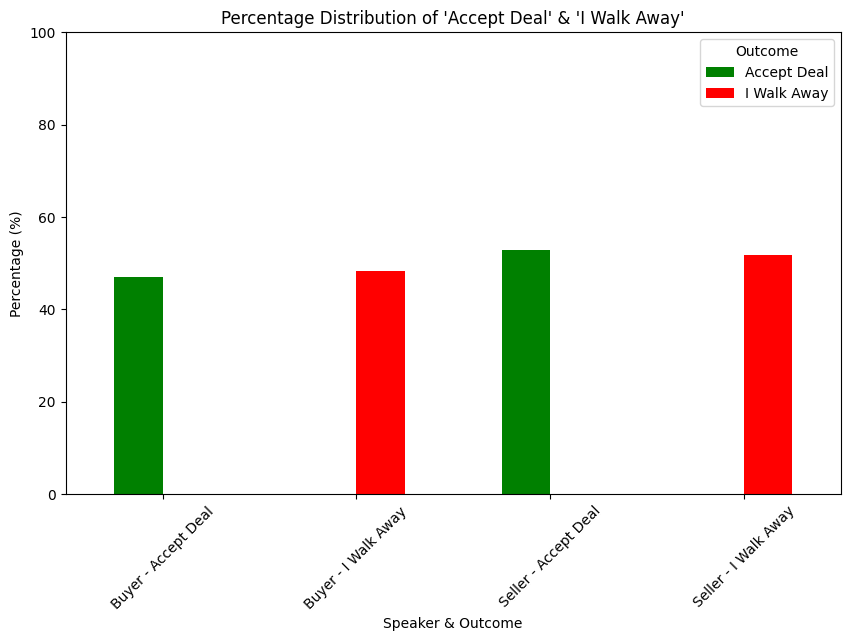

In [20]:
# Apply mapping to final_success_df_counts
flag_speaker_map = {
    0: "Buyer - I Walk Away",
    1: "Buyer - Accept Deal",
    2: "Seller - I Walk Away",
    3: "Seller - Accept Deal"
}

flag_speaker_counts_accept = final_success_df["flag_speaker"].value_counts()

flag_speaker_counts_reject = final_reject_df["flag_speaker"].value_counts()

flag_speaker_counts_accept.index = flag_speaker_counts_accept.index.map(flag_speaker_map)
print(flag_speaker_counts_accept)
# Apply mapping to final_reject_df_counts
flag_speaker_counts_reject.index = flag_speaker_counts_reject.index.map(flag_speaker_map)
display(flag_speaker_counts_reject)


import matplotlib.pyplot as plt
# Calculate total counts per outcome
total_accept_deals = flag_speaker_counts_accept.sum()  # 918 + 818
total_rejects = flag_speaker_counts_reject.sum()  # 240 + 224

# Convert to percentage within each category
accept_deals_percent = (flag_speaker_counts_accept / total_accept_deals) * 100
reject_deals_percent = (flag_speaker_counts_reject / total_rejects) * 100

# Combine both into a single DataFrame
flag_speaker_percentage = pd.DataFrame({
    "Accept Deal": accept_deals_percent,
    "I Walk Away": reject_deals_percent
}).fillna(0)  # Fill NaN values with 0

# Plot the percentage data
flag_speaker_percentage.plot(kind="bar", figsize=(10, 6), color=["green", "red"])

# Add labels and title
plt.xlabel("Speaker & Outcome")
plt.ylabel("Percentage (%)")
plt.title("Percentage Distribution of 'Accept Deal' & 'I Walk Away'")
plt.legend(title="Outcome")
plt.xticks(rotation=45)  # Rotate labels for readability
plt.ylim(0, 100)  # Ensure y-axis is between 0 and 100%

# Show the plot
plt.show()


### **Total number of Accepted/Rejected Deals**


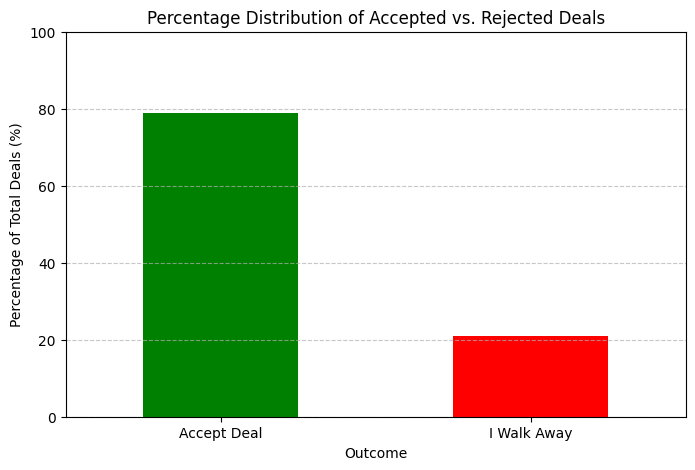

In [21]:
# Total counts for accepted and rejected deals
total_accept_deals = flag_speaker_counts_accept.sum()  # 918 + 818
total_rejects = flag_speaker_counts_reject.sum()  # 240 + 224
total_deals = total_accept_deals + total_rejects  # Total transactions

# Compute percentage of total deals
deal_outcomes_percentage = pd.Series({
    "Accept Deal": (total_accept_deals / total_deals) * 100,
    "I Walk Away": (total_rejects / total_deals) * 100
})

# Plot
deal_outcomes_percentage.plot(kind="bar", figsize=(8, 5), color=["green", "red"])

# Labels & title
plt.xlabel("Outcome")
plt.ylabel("Percentage of Total Deals (%)")
plt.title("Percentage Distribution of Accepted vs. Rejected Deals")
plt.ylim(0, 100)  # Ensure percentage scale
plt.xticks(rotation=0)  # Keep labels horizontal for readability
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Add horizontal grid lines for clarity

# Show plot
plt.show()

# Save Final Valid Dataframe to CSV file

### **Setting Final dataframes**

In [22]:

data_preprocessor.filterValidOutcomes()
data_preprocessor.getDataframe()


,b_country,b_RankBuy_1,b_RankBuy_2,b_RankBuy_3,b_RankBuy_4,b_Tact_1,b_Tact_2,b_Tact_3,b_Tact_4,b_Tact_5,...,s_AI4u,s_PlayAI.1,s_AI-cues.1,is_AI,formattedChat,b_insight,s_insight,parsed_dialog,flag_speaker,dispute_outcome
1,187.0,40.0,10.0,31.0,19.0,3.0,1.0,2.0,NaN,1.0,...,NaN,NaN,NaN,False,1699388451 Buyer: Hi there! I believe I receiv...,3.0,1.0,"[{'timestamp': 1699388451, 'speaker': 'Buyer',...",3.0,1.0
6,187.0,50.0,8.0,30.0,12.0,2.0,5.0,4.0,NaN,4.0,...,NaN,NaN,NaN,False,1699389969 Buyer: Hello. I need you to make th...,2.0,6.0,"[{'timestamp': 1699389969, 'speaker': 'Buyer',...",3.0,1.0
9,187.0,80.0,0.0,20.0,0.0,1.0,3.0,4.0,NaN,4.0,...,NaN,NaN,NaN,False,1699392080 Buyer: I would prefer a refund as t...,2.0,5.0,"[{'timestamp': 1699392080, 'speaker': 'Buyer',...",1.0,1.0
10,187.0,40.0,30.0,20.0,10.0,2.0,3.0,3.0,NaN,4.0,...,NaN,NaN,NaN,False,1699392404 Buyer: I didn't receive the correct...,NaN,NaN,"[{'timestamp': 1699392404, 'speaker': 'Buyer',...",3.0,1.0
12,187.0,90.0,5.0,5.0,0.0,1.0,4.0,2.0,NaN,3.0,...,NaN,NaN,NaN,False,1699393461 Buyer: Hello! I need you to refund ...,3.0,0.0,"[{'timestamp': 1699393461, 'speaker': 'Buyer',...",1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2866,161.0,50.0,10.0,15.0,25.0,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,The conversation was emotions and had typing e...,False,"1718874750 Buyer: My product arrived broken , ...",1.0,2.0,"[{'timestamp': 1718874750, 'speaker': 'Buyer',...",3.0,1.0
2869,161.0,15.0,20.0,25.0,40.0,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,because he responded genuinely,False,1718875387 Buyer: Hello i requesting for a par...,2.0,6.0,"[{'timestamp': 1718875387, 'speaker': 'Buyer',...",3.0,1.0
2871,185.0,75.0,0.0,25.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,"1718875699 Buyer: I would like a refund, the b...",NaN,NaN,"[{'timestamp': 1718875699, 'speaker': 'Buyer',...",1.0,1.0
2872,161.0,35.0,20.0,30.0,15.0,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,sentences were short and minimal information g...,False,"1718876074 Buyer: Hey, I received my order and...",4.0,3.0,"[{'timestamp': 1718876074, 'speaker': 'Buyer',...",3.0,1.0


Data type of parsed_dialog: <class 'list'>


,b_country,b_RankBuy_1,b_RankBuy_2,b_RankBuy_3,b_RankBuy_4,b_Tact_1,b_Tact_2,b_Tact_3,b_Tact_4,b_Tact_5,...,s_AI4u,s_PlayAI.1,s_AI-cues.1,is_AI,formattedChat,b_insight,s_insight,parsed_dialog,flag_speaker,dispute_outcome
0,187.0,80.0,12.0,5.0,3.0,1.0,4.0,5.0,NaN,1.0,...,NaN,NaN,NaN,True,nan Seller: Your sudden demand for a refund is...,NaN,NaN,"[{'timestamp': 'nan', 'speaker': 'Seller', 'me...",0.0,0.0
1,187.0,40.0,10.0,31.0,19.0,3.0,1.0,2.0,NaN,1.0,...,NaN,NaN,NaN,False,1699388451 Buyer: Hi there! I believe I receiv...,3.0,1.0,"[{'timestamp': 1699388451, 'speaker': 'Buyer',...",3.0,1.0
6,187.0,50.0,8.0,30.0,12.0,2.0,5.0,4.0,NaN,4.0,...,NaN,NaN,NaN,False,1699389969 Buyer: Hello. I need you to make th...,2.0,6.0,"[{'timestamp': 1699389969, 'speaker': 'Buyer',...",3.0,1.0
9,187.0,80.0,0.0,20.0,0.0,1.0,3.0,4.0,NaN,4.0,...,NaN,NaN,NaN,False,1699392080 Buyer: I would prefer a refund as t...,2.0,5.0,"[{'timestamp': 1699392080, 'speaker': 'Buyer',...",1.0,1.0
10,187.0,40.0,30.0,20.0,10.0,2.0,3.0,3.0,NaN,4.0,...,NaN,NaN,NaN,False,1699392404 Buyer: I didn't receive the correct...,NaN,NaN,"[{'timestamp': 1699392404, 'speaker': 'Buyer',...",3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2869,161.0,15.0,20.0,25.0,40.0,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,because he responded genuinely,False,1718875387 Buyer: Hello i requesting for a par...,2.0,6.0,"[{'timestamp': 1718875387, 'speaker': 'Buyer',...",3.0,1.0
2870,137.0,90.0,0.0,10.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,how he responded,False,"1718875522 Buyer: Hello, I would like to recei...",0.0,1.0,"[{'timestamp': 1718875522, 'speaker': 'Buyer',...",2.0,0.0
2871,185.0,75.0,0.0,25.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,"1718875699 Buyer: I would like a refund, the b...",NaN,NaN,"[{'timestamp': 1718875699, 'speaker': 'Buyer',...",1.0,1.0
2872,161.0,35.0,20.0,30.0,15.0,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,sentences were short and minimal information g...,False,"1718876074 Buyer: Hey, I received my order and...",4.0,3.0,"[{'timestamp': 1718876074, 'speaker': 'Buyer',...",3.0,1.0


In [23]:
data_preprocessor.filterMatches('message', "I Walk Away")
data_preprocessor.getDataframe()

,b_country,b_RankBuy_1,b_RankBuy_2,b_RankBuy_3,b_RankBuy_4,b_Tact_1,b_Tact_2,b_Tact_3,b_Tact_4,b_Tact_5,...,s_AI4u,s_PlayAI.1,s_AI-cues.1,is_AI,formattedChat,b_insight,s_insight,parsed_dialog,flag_speaker,dispute_outcome
0,187.0,80.0,12.0,5.0,3.0,1.0,4.0,5.0,NaN,1.0,...,NaN,NaN,NaN,True,nan Seller: Your sudden demand for a refund is...,NaN,NaN,"[{'timestamp': 'nan', 'speaker': 'Seller', 'me...",0.0,0.0
1,187.0,40.0,10.0,31.0,19.0,3.0,1.0,2.0,NaN,1.0,...,NaN,NaN,NaN,False,1699388451 Buyer: Hi there! I believe I receiv...,3.0,1.0,"[{'timestamp': 1699388451, 'speaker': 'Buyer',...",3.0,1.0
6,187.0,50.0,8.0,30.0,12.0,2.0,5.0,4.0,NaN,4.0,...,NaN,NaN,NaN,False,1699389969 Buyer: Hello. I need you to make th...,2.0,6.0,"[{'timestamp': 1699389969, 'speaker': 'Buyer',...",3.0,1.0
9,187.0,80.0,0.0,20.0,0.0,1.0,3.0,4.0,NaN,4.0,...,NaN,NaN,NaN,False,1699392080 Buyer: I would prefer a refund as t...,2.0,5.0,"[{'timestamp': 1699392080, 'speaker': 'Buyer',...",1.0,1.0
10,187.0,40.0,30.0,20.0,10.0,2.0,3.0,3.0,NaN,4.0,...,NaN,NaN,NaN,False,1699392404 Buyer: I didn't receive the correct...,NaN,NaN,"[{'timestamp': 1699392404, 'speaker': 'Buyer',...",3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2869,161.0,15.0,20.0,25.0,40.0,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,because he responded genuinely,False,1718875387 Buyer: Hello i requesting for a par...,2.0,6.0,"[{'timestamp': 1718875387, 'speaker': 'Buyer',...",3.0,1.0
2870,137.0,90.0,0.0,10.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,how he responded,False,"1718875522 Buyer: Hello, I would like to recei...",0.0,1.0,"[{'timestamp': 1718875522, 'speaker': 'Buyer',...",2.0,0.0
2871,185.0,75.0,0.0,25.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,"1718875699 Buyer: I would like a refund, the b...",NaN,NaN,"[{'timestamp': 1718875699, 'speaker': 'Buyer',...",1.0,1.0
2872,161.0,35.0,20.0,30.0,15.0,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,sentences were short and minimal information g...,False,"1718876074 Buyer: Hey, I received my order and...",4.0,3.0,"[{'timestamp': 1718876074, 'speaker': 'Buyer',...",3.0,1.0


In [24]:
# Ensure the folder exists before saving
# Save DataFrame to CSV
data_preprocessor.saveToCSV(final_filepath)
test = pd.read_csv("/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/preprocessed_dyads.csv")


Data saved to /Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/preprocessed_dyads.csv


In [25]:
test = DataPreprocesser(final_filepath)

2200
